In [5]:
import pandas as pd
base = "../data"
prep = f"{base}/prepared.csv"
df_small = pd.read_csv(prep)

In [6]:
df_small.dropna(subset=['text'], inplace=True)
df_small.sample()

,toxic,text
1329,0.0,provence nice hello deletion picture nice arti...


In [7]:
X, y = df_small['text'], df_small['toxic']

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
X = tfidf.fit_transform(X).toarray()

In [9]:
X.shape

(160511, 4000)

In [10]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [12]:
clf = RandomForestClassifier(n_estimators=40, verbose=1, random_state=RANDOM_STATE, n_jobs=-1)
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

In [13]:
models = {'LogisticRegression': lr, 'CatBoostClassifier': cb, 'RandomForestClassifier': clf}
scores = dict()

In [14]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_model_perfection_metrics(y_test, y_pred, model_name):
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1:.10}")
    scores[model_name] = f1

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.show()

In [15]:
import pickle 

model_base = f"../models"

def fit_predict(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    show_model_perfection_metrics(y_pred=y_pred, y_test=y_test, model_name=model_name)

training model LogisticRegression
F1: 0.9536486282


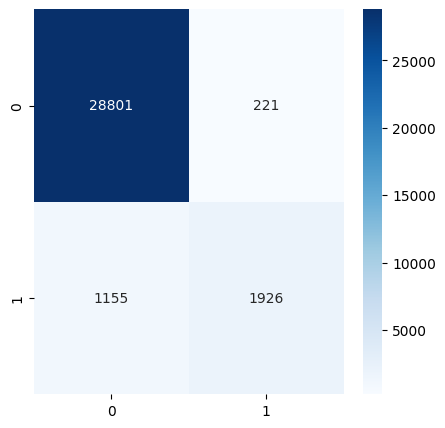

training model CatBoostClassifier
F1: 0.9538176516


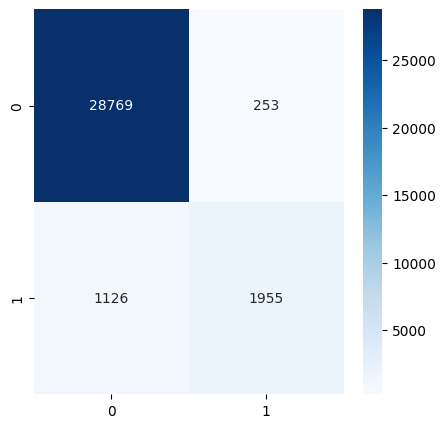

training model RandomForestClassifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


F1: 0.951099845


[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:    0.2s finished


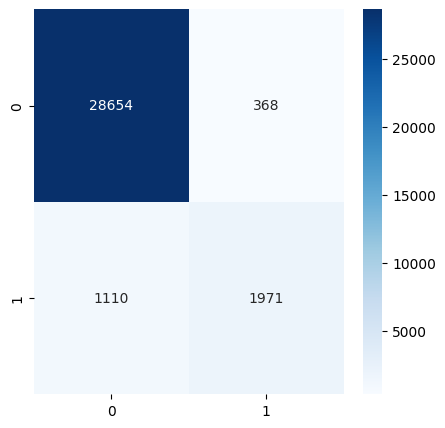

In [16]:
for name, model in models.items():
    print(f"training model {name}")
    fit_predict(model, X_train, X_test, y_train, y_test, model_name=name)

In [17]:
def save_model(model, model_name):
    print(f"saving model {model_name}")
    with open(f"{model_base}/{model_name}.pkl", 'wb') as f:
        pickle.dump(model, f)

In [18]:
for name, model in models.items():
    save_model(model, name)
save_model(tfidf, "TfidfVectorizer")

saving model LogisticRegression
saving model CatBoostClassifier
saving model RandomForestClassifier
saving model TfidfVectorizer


Let's try model tandem

In [21]:
y_pred_lr = lr.predict(X_test)
y_pred_cb = cb.predict(X_test)
y_pred_clf = clf.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:    0.1s finished


F1: 0.9539075552


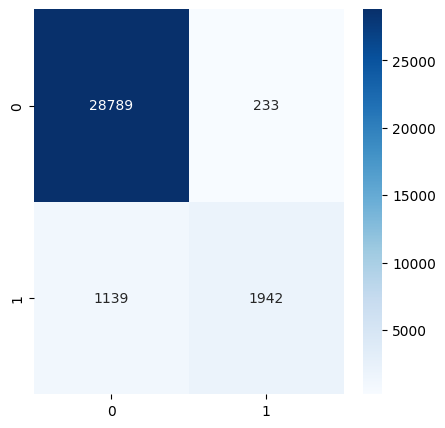

In [25]:
y_pred_aver = (y_pred_lr + y_pred_cb + y_pred_clf) / 3
y_pred_round = y_pred_aver.round()
show_model_perfection_metrics(y_pred=y_pred_round, y_test=y_test, model_name="tandem")

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [16]:
max_features = 20000
embedding_dim = 128
sequence_length = 500

model = Sequential([
    Embedding(max_features, embedding_dim),
    Dropout(0.5),

    Conv1D(embedding_dim, 7, activation='relu', padding='valid', strides=3),
    Conv1D(embedding_dim, 7, activation='relu', padding='valid', strides=3),
    GlobalMaxPooling1D(),

    Dense(embedding_dim, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid', name='predictions')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/5
4013/4013 ━━━━━━━━━━━━━━━━━━━━ 1582s 394ms/step - accuracy: 0.8988 - loss: 0.3378 - val_accuracy: 0.9040 - val_loss: 0.3184
Epoch 2/5
4013/4013 ━━━━━━━━━━━━━━━━━━━━ 1711s 426ms/step - accuracy: 0.9005 - loss: 0.3291 - val_accuracy: 0.9040 - val_loss: 0.3162
Epoch 3/5
4013/4013 ━━━━━━━━━━━━━━━━━━━━ 1721s 429ms/step - accuracy: 0.8992 - loss: 0.3296 - val_accuracy: 0.9040 - val_loss: 0.3162
Epoch 4/5
4013/4013 ━━━━━━━━━━━━━━━━━━━━ 2068s 515ms/step - accuracy: 0.9001 - loss: 0.3264 - val_accuracy: 0.9040 - val_loss: 0.3162
Epoch 5/5
4013/4013 ━━━━━━━━━━━━━━━━━━━━ 2100s 510ms/step - accuracy: 0.9015 - loss: 0.3231 - val_accuracy: 0.9040 - val_loss: 0.3163


In [18]:
model.save(f"{model_base}/nn.keras")

In [19]:
for model, f1 in scores.items():
    print(f"{model} f1 score is {f1:.10}")

LogisticRegression f1 score is 0.9536486282
CatBoostClassifier f1 score is 0.9538176516
RandomForestClassifier f1 score is 0.951099845
